# Udacity Data Engineering Capstone Project:  Energy usage and weather database

#### Project Summary
For the Udacity Capstone project I have sourced my own datasets which I will use to build an analytics database which includes data on energy usage from smart meters in London, temperature and weather warnings.

This database is intended to allow the analytics team to gain insights into how weather influence energy usage

The project will bring together learnings from the Udacity Data Engineering programme including data wrangling, data lakes, data warehouses and Cloud Computing.

For this project I will first gather, assess and clean my data.  I will then define a data model which will be realised by a process which involves staging the data as csv files on S3 before loading to Redshift (with the Redshift Cluster launched using Infrastructure as Code).

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Imports and installs
!pip install wptools
!pip install tweepy
!pip install boto3
!pip install ipython-sql
!pip install psycopg2-binary
!pip install s3fs
import pandas as pd
import requests
import wptools
import os
import numpy as np
import tweepy
from bs4 import BeautifulSoup
import json
import glob
import matplotlib.pyplot as plt
import boto3
import configparser
import psycopg2

  Using cached botocore-1.23.24-py3-none-any.whl (8.4 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.22.8
    Uninstalling botocore-1.22.8:
      Successfully uninstalled botocore-1.22.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.23.24 which is incompatible.
  Using cached botocore-1.22.8-py3-none-any.whl (8.1 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.23.24
    Uninstalling botocore-1.23.24:
      Successfully uninstalled botocore-1.23.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.20.23 requires botocore<1.24.0,>=1.23.23, but you have botocore 1.22.8 which is incompatible

### Step 1: Scope the Project and Gather Data

#### Scope 
Would like to use the data to prepare an analytics database where we have tables where the fact is the energy usage and we then have dimensions tables covering weather warnings and temperature to allow an understanding as to how weather influence energy usage

#### Describe and Gather Data 
The following data will be gathered to allow build of the analytics database:
- Smart meters in London dataset (sourced from Kaggle) - https://www.kaggle.com/jeanmidev/smart-meters-in-london
- Met Office weather warnings for South East England (sourced from Twitter via API) - https://twitter.com/metofficeSEEng
- Temperature data by day for Heathrow (London) (sourced from CEDA) - https://data.ceda.ac.uk/badc/ukmo-midas-open/data/uk-daily-temperature-obs/dataset-version-202107/greater-london/00708_heathrow/qc-version-1

#### 1a. Import the csv file downloaded from Kaggle with hourly readings from Smart Meters in London
- https://www.kaggle.com/jeanmidev/smart-meters-in-london

In [2]:
# Import the csv file of smart meters data into a DataFrame
meters_df = pd.read_csv('smart_meters/daily_dataset.csv')

In [3]:
# Sense check that the data has been loaded to a dataframe as expected
meters_df.head()

LCLid         day  energy_median  energy_mean  energy_max  \
0  MAC000131  2011-12-15         0.4850     0.432045       0.868   
1  MAC000131  2011-12-16         0.1415     0.296167       1.116   
2  MAC000131  2011-12-17         0.1015     0.189812       0.685   
3  MAC000131  2011-12-18         0.1140     0.218979       0.676   
4  MAC000131  2011-12-19         0.1910     0.325979       0.788   

   energy_count  energy_std  energy_sum  energy_min  
0            22    0.239146       9.505       0.072  
1            48    0.281471      14.216       0.031  
2            48    0.188405       9.111       0.064  
3            48    0.202919      10.511       0.065  
4            48    0.259205      15.647       0.066

#### 1b. Pull Twitter data using the Tweepy API from Met Office South East England weather warning page
- https://twitter.com/metofficeSEEng

In [4]:
# Establish connection to Twitter API using Tweepy
consumer_key = 'BauIz72Gp8ZeUZOMloSc6oNMX'
consumer_secret = 'WTMUaH31H1XaeuK9c9bnESe0TkoxsqsuNQwEGAHMz6LfYZdvip'
access_token = '1430241949437632513-vXFRYdd7KBbl9PXDSo5Fr6xhVihzDA'
access_secret = 'awUtUFWCmPU7IUBFl7ve9IGIQrnoEetaSJCSqHj23HbyI'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, parser=tweepy.parsers.JSONParser())

In [5]:
with open('tweet_json.txt', 'w') as outfile:
    for tweet in tweepy.Cursor(api.user_timeline, screen_name='@metofficeSEEng', tweet_mode="extended").items():
        # Write the data to the json file 'tweet_json.txt'
        outfile.write(json.dumps(tweet)+'\n')
        # Print the tweet for sense check that it is running
        print(tweet)

{'created_at': 'Mon Dec 06 11:18:05 +0000 2021', 'id': 1467815602848874498, 'id_str': '1467815602848874498', 'full_text': 'Yellow warning of wind affecting London &amp; South East England https://t.co/nL2Z6jTa6x https://t.co/iGJAKotfQF', 'truncated': False, 'display_text_range': [0, 88], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/nL2Z6jTa6x', 'expanded_url': 'http://dlvr.it/SDqwvK', 'display_url': 'dlvr.it/SDqwvK', 'indices': [65, 88]}], 'media': [{'id': 1467815601154375683, 'id_str': '1467815601154375683', 'indices': [89, 112], 'media_url': 'http://pbs.twimg.com/media/FF66gy6VQAMuh06.jpg', 'media_url_https': 'https://pbs.twimg.com/media/FF66gy6VQAMuh06.jpg', 'url': 'https://t.co/iGJAKotfQF', 'display_url': 'pic.twitter.com/iGJAKotfQF', 'expanded_url': 'https://twitter.com/metofficeSEEng/status/1467815602848874498/photo/1', 'type': 'photo', 'sizes': {'small': {'w': 680, 'h': 375, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resiz

In [6]:
# Create an empty list which we will populate with the data we need line by line
tweet_in_list = []

# Read in the json file to a dataframe
with open ('tweet_json.txt', 'r') as infile:
    for tweet in infile:
        line = json.loads(tweet)
        tweet_in_list.append({"tweet_id": line["id"],
                             "full_text": line["full_text"],
                             "retweet_count": line["retweet_count"],
                             "favorite_count": line["favorite_count"],
                             "created_at": line["created_at"],
                             "user_id": line["user"]["screen_name"]
                             })

In [7]:
# Sense check that the data has been loaded to a list as expected
tweet_in_list[0:5]

[{'tweet_id': 1467815602848874498,
  'full_text': 'Yellow warning of wind affecting London &amp; South East England https://t.co/nL2Z6jTa6x https://t.co/iGJAKotfQF',
  'retweet_count': 16,
  'favorite_count': 10,
  'created_at': 'Mon Dec 06 11:18:05 +0000 2021',
  'user_id': 'metofficeSEEng'},
 {'tweet_id': 1467806282077798408,
  'full_text': 'Yellow warning of wind affecting London &amp; South East England https://t.co/VXsP6qYcMa https://t.co/RcuMdRivSy',
  'retweet_count': 2,
  'favorite_count': 3,
  'created_at': 'Mon Dec 06 10:41:02 +0000 2021',
  'user_id': 'metofficeSEEng'},
 {'tweet_id': 1467449437140049920,
  'full_text': 'Yellow warning of wind affecting London &amp; South East England https://t.co/Q0MFGWVzcX https://t.co/IuAYfhPDOI',
  'retweet_count': 12,
  'favorite_count': 9,
  'created_at': 'Sun Dec 05 11:03:04 +0000 2021',
  'user_id': 'metofficeSEEng'},
 {'tweet_id': 1466078155739783168,
  'full_text': 'Yellow warning of ice affecting London &amp; South East England htt

In [8]:
# Convert the list to a dataframe
tweets_df = pd.DataFrame(tweet_in_list)

In [9]:
# Sense check that the data has been loaded to a dataframe as expected
tweets_df.head()

tweet_id                                          full_text  \
0  1467815602848874498  Yellow warning of wind affecting London &amp; ...   
1  1467806282077798408  Yellow warning of wind affecting London &amp; ...   
2  1467449437140049920  Yellow warning of wind affecting London &amp; ...   
3  1466078155739783168  Yellow warning of ice affecting London &amp; S...   
4  1464956381207805953  Yellow warning of snow affecting London &amp; ...   

   retweet_count  favorite_count                      created_at  \
0             16              10  Mon Dec 06 11:18:05 +0000 2021   
1              2               3  Mon Dec 06 10:41:02 +0000 2021   
2             12               9  Sun Dec 05 11:03:04 +0000 2021   
3              9               8  Wed Dec 01 16:14:05 +0000 2021   
4              7              19  Sun Nov 28 13:56:33 +0000 2021   

          user_id  
0  metofficeSEEng  
1  metofficeSEEng  
2  metofficeSEEng  
3  metofficeSEEng  
4  metofficeSEEng

#### 1c. Import the csv files downloaded from CEDA with daily temperature as recorded at Heathrow
- https://data.ceda.ac.uk/badc/ukmo-midas-open/data/uk-daily-temperature-obs/dataset-version-202107/greater-london/00708_heathrow/qc-version-1

In [10]:
# Code to iterate over csvs to combine into one dataframe taken from stackoverflow,
# - https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe

path = 'temperature_heathrow' # use your path
all_files = glob.glob(path + "/*.csv")

csv_list = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=90)
    csv_list.append(df)

temp_df = pd.concat(csv_list, axis=0, ignore_index=True)

In [11]:
# Sense check that the data has been loaded to a dataframe as expected
temp_df.head()

ob_end_time id_type      id  ob_hour_count  version_num  \
0  2016-01-01 09:00:00    DCNN  5113.0           12.0          1.0   
1  2016-01-01 21:00:00    DCNN  5113.0           12.0          1.0   
2  2016-01-02 09:00:00    DCNN  5113.0           12.0          1.0   
3  2016-01-02 21:00:00    DCNN  5113.0           12.0          1.0   
4  2016-01-03 09:00:00    DCNN  5113.0           12.0          1.0   

  met_domain_name  src_id  rec_st_ind  max_air_temp  min_air_temp  ...  \
0             NCM   708.0      1011.0           7.1           1.3  ...   
1             NCM   708.0      1011.0           8.6           2.2  ...   
2             NCM   708.0      1011.0           9.9           7.8  ...   
3             NCM   708.0      1011.0          11.3           9.7  ...   
4             NCM   708.0      1011.0          10.1           4.9  ...   

   max_air_temp_q  min_air_temp_q  min_grss_temp_q  min_conc_temp_q  \
0             6.0             6.0              6.0              6.0   
1             6.0             6.0              NaN              NaN   
2             6.0             6.0              6.0              6.0   
3             6.0             6.0              NaN              NaN   
4             6.0             6.0              6.0              6.0   

   max_air_temp_j  min_air_temp_j  min_grss_temp_j  min_conc_temp_j  \
0             NaN             NaN              NaN              NaN   
1             NaN             NaN              NaN              NaN   
2             NaN             NaN              NaN              NaN   
3             NaN             NaN              NaN              NaN   
4             NaN             NaN              NaN              NaN   

        meto_stmp_time  midas_stmp_etime  
0  2016-01-01 08:55:00               0.0  
1  2016-01-01 20:54:00               0.0  
2  2016-01-02 08:54:00               0.0  
3  2016-01-02 20:56:00               0.0  
4  2016-01-03 08:54:00               0.0  

[5 rows x 22 columns]

### Step 2: Explore and Assess the Data
#### 1. Explore the Data

### Visual assessment

In [12]:
# Configure pandas options to display all columns
pd.set_option('display.max_columns', None)

#### 1a. Smart Meters DataFrame (meters_df)

In [13]:
# Take a look at the meters_df dataframe to visually inspect (sort by tweet_id to allow comparisons between dataframes)
meters_df

LCLid         day  energy_median  energy_mean  energy_max  \
0        MAC000131  2011-12-15         0.4850     0.432045       0.868   
1        MAC000131  2011-12-16         0.1415     0.296167       1.116   
2        MAC000131  2011-12-17         0.1015     0.189812       0.685   
3        MAC000131  2011-12-18         0.1140     0.218979       0.676   
4        MAC000131  2011-12-19         0.1910     0.325979       0.788   
...            ...         ...            ...          ...         ...   
3510428  MAC004977  2014-02-24         0.0950     0.118458       0.580   
3510429  MAC004977  2014-02-25         0.0675     0.084208       0.176   
3510430  MAC004977  2014-02-26         0.1080     0.120500       0.282   
3510431  MAC004977  2014-02-27         0.0720     0.114062       0.431   
3510432  MAC004977  2014-02-28         0.0970     0.097000       0.097   

         energy_count  energy_std  energy_sum  energy_min  
0                  22    0.239146       9.505       0.072  
1                  48    0.281471      14.216       0.031  
2                  48    0.188405       9.111       0.064  
3                  48    0.202919      10.511       0.065  
4                  48    0.259205      15.647       0.066  
...               ...         ...         ...         ...  
3510428            48    0.093814       5.686       0.052  
3510429            48    0.037107       4.042       0.046  
3510430            48    0.069332       5.784       0.046  
3510431            48    0.094482       5.475       0.047  
3510432             1         NaN       0.097       0.097  

[3510433 rows x 9 columns]

#### 1b. Twitter DataFrame (tweets_df)

In [14]:
# Take a look at the tweets_df dataframe to visually inspect
tweets_df

tweet_id                                          full_text  \
0     1467815602848874498  Yellow warning of wind affecting London &amp; ...   
1     1467806282077798408  Yellow warning of wind affecting London &amp; ...   
2     1467449437140049920  Yellow warning of wind affecting London &amp; ...   
3     1466078155739783168  Yellow warning of ice affecting London &amp; S...   
4     1464956381207805953  Yellow warning of snow affecting London &amp; ...   
...                   ...                                                ...   
1146           8573976314  ADVISORY of Heavy Snow for London & South East...   
1147           8564745617  FLASH Warning of Widespread Icy Roads for Lond...   
1148           8488362035  FLASH Warning of Widespread Icy Roads for Lond...   
1149           8479464283  FLASH Warning of Widespread Icy Roads for Lond...   
1150           8477820271  FLASH Warning of Widespread Icy Roads for Lond...   

      retweet_count  favorite_count                      created_at  \
0                16              10  Mon Dec 06 11:18:05 +0000 2021   
1                 2               3  Mon Dec 06 10:41:02 +0000 2021   
2                12               9  Sun Dec 05 11:03:04 +0000 2021   
3                 9               8  Wed Dec 01 16:14:05 +0000 2021   
4                 7              19  Sun Nov 28 13:56:33 +0000 2021   
...             ...             ...                             ...   
1146              2               1  Wed Feb 03 04:16:05 +0000 2010   
1147              0               0  Wed Feb 03 00:14:48 +0000 2010   
1148              0               0  Mon Feb 01 06:21:09 +0000 2010   
1149              0               0  Mon Feb 01 02:41:06 +0000 2010   
1150              0               0  Mon Feb 01 02:08:34 +0000 2010   

             user_id  
0     metofficeSEEng  
1     metofficeSEEng  
2     metofficeSEEng  
3     metofficeSEEng  
4     metofficeSEEng  
...              ...  
1146  metofficeSEEng  
1147  metofficeSEEng  
1148  metofficeSEEng  
1149  metofficeSEEng  
1150  metofficeSEEng  

[1151 rows x 6 columns]

#### 1c. Temperature DataFrame (temp_df)

In [15]:
# Take a look at the temp_df dataframe to visually inspect
temp_df

ob_end_time id_type      id  ob_hour_count  version_num  \
0     2016-01-01 09:00:00    DCNN  5113.0           12.0          1.0   
1     2016-01-01 21:00:00    DCNN  5113.0           12.0          1.0   
2     2016-01-02 09:00:00    DCNN  5113.0           12.0          1.0   
3     2016-01-02 21:00:00    DCNN  5113.0           12.0          1.0   
4     2016-01-03 09:00:00    DCNN  5113.0           12.0          1.0   
...                   ...     ...     ...            ...          ...   
8042  2017-12-30 09:00:00    DCNN  5113.0           12.0          1.0   
8043  2017-12-30 21:00:00    DCNN  5113.0           12.0          1.0   
8044  2017-12-31 09:00:00    DCNN  5113.0           12.0          1.0   
8045  2017-12-31 21:00:00    DCNN  5113.0           12.0          1.0   
8046             end data     NaN     NaN            NaN          NaN   

     met_domain_name  src_id  rec_st_ind  max_air_temp  min_air_temp  \
0                NCM   708.0      1011.0           7.1           1.3   
1                NCM   708.0      1011.0           8.6           2.2   
2                NCM   708.0      1011.0           9.9           7.8   
3                NCM   708.0      1011.0          11.3           9.7   
4                NCM   708.0      1011.0          10.1           4.9   
...              ...     ...         ...           ...           ...   
8042             NCM   708.0      1011.0          12.5           5.1   
8043             NCM   708.0      1011.0          14.4          10.8   
8044             NCM   708.0      1011.0          13.0           9.0   
8045             NCM   708.0      1011.0          11.6           8.1   
8046             NaN     NaN         NaN           NaN           NaN   

      min_grss_temp  min_conc_temp  max_air_temp_q  min_air_temp_q  \
0              -3.5            0.2             6.0             6.0   
1               NaN            NaN             6.0             6.0   
2               7.0            6.7             6.0             6.0   
3               NaN            NaN             6.0             6.0   
4               2.2            3.9             6.0             6.0   
...             ...            ...             ...             ...   
8042            1.8            1.4             6.0             6.0   
8043            NaN            NaN             6.0             6.0   
8044            8.4            8.2             6.0             6.0   
8045            NaN            NaN             6.0             6.0   
8046            NaN            NaN             NaN             NaN   

      min_grss_temp_q  min_conc_temp_q  max_air_temp_j  min_air_temp_j  \
0                 6.0              6.0             NaN             NaN   
1                 NaN              NaN             NaN             NaN   
2                 6.0              6.0             NaN             NaN   
3                 NaN              NaN             NaN             NaN   
4                 6.0              6.0             NaN             NaN   
...               ...              ...             ...             ...   
8042              6.0              6.0             NaN             NaN   
8043              NaN              NaN             NaN             NaN   
8044              6.0              6.0             NaN             NaN   
8045              NaN              NaN             NaN             NaN   
8046              NaN              NaN             NaN             NaN   

      min_grss_temp_j  min_conc_temp_j       meto_stmp_time  midas_stmp_etime  
0                 NaN              NaN  2016-01-01 08:55:00               0.0  
1                 NaN              NaN  2016-01-01 20:54:00               0.0  
2                 NaN              NaN  2016-01-02 08:54:00               0.0  
3                 NaN              NaN  2016-01-02 20:56:00               0.0  
4                 NaN              NaN  2016-01-03 08:54:00               0.0  
...               ...              ...                  ...   

### Programatic assessment

#### 1a. Smart Meters DataFrame (meters_df)

In [16]:
# Get info on the DataFrame (number of records, column names and datatypes)
meters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   LCLid          object 
 1   day            object 
 2   energy_median  float64
 3   energy_mean    float64
 4   energy_max     float64
 5   energy_count   int64  
 6   energy_std     float64
 7   energy_sum     float64
 8   energy_min     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 241.0+ MB


In [17]:
# Check a sample of records
meters_df.sample(25)

LCLid         day  energy_median  energy_mean  energy_max  \
3143392  MAC002406  2013-12-15         0.2335     0.261354       1.162   
465103   MAC004340  2012-05-08         0.0960     0.167687       0.776   
2730104  MAC000666  2013-01-23         0.0780     0.108792       0.328   
887056   MAC004175  2013-09-28         0.1100     0.128667       0.825   
970959   MAC004570  2013-06-27         0.1570     0.181771       0.600   
1025036  MAC004227  2013-01-25         0.0950     0.093479       0.112   
691130   MAC001457  2014-02-11         0.0460     0.065917       0.257   
3087551  MAC001853  2013-11-01         0.3325     0.480625       1.393   
543251   MAC004999  2013-08-29         0.1000     0.169875       0.774   
1693293  MAC005246  2012-05-15         0.1715     0.212917       2.201   
2448923  MAC000471  2012-08-09         0.1685     0.192917       0.484   
633158   MAC004116  2013-01-06         0.2050     0.300333       1.452   
978870   MAC001468  2013-04-23         0.1930     0.216729       0.448   
2519711  MAC004061  2012-08-18         0.1800     0.280958       0.833   
2225039  MAC002391  2012-07-19         0.0665     0.103958       0.564   
2764523  MAC000485  2013-07-17         0.0790     0.085167       0.391   
3493505  MAC001526  2014-01-17         0.0150     0.022500       0.039   
2341625  MAC004443  2013-04-10         0.1270     0.279167       0.890   
639403   MAC004325  2012-03-17         0.3160     0.472750       1.516   
1020203  MAC004195  2014-01-02         0.2150     0.311854       1.249   
67582    MAC000091  2012-11-25         0.0660     0.078583       0.148   
680852   MAC000358  2012-09-23         1.1660     1.219021       3.431   
3368118  MAC002704  2013-06-01         0.1740     0.187938       0.606   
2883261  MAC000335  2012-08-06         0.1105     0.135542       0.466   
1415916  MAC004801  2012-12-14         0.2760     0.216354       0.409   

         energy_count  energy_std  energy_sum  energy_min  
3143392            48    0.236432      12.545       0.038  
465103             48    0.155130       8.049       0.054  
2730104            48    0.084885       5.222       0.010  
887056             48    0.159324       6.176       0.007  
970959             48    0.090373       8.725       0.094  
1025036            48    0.013362       4.487       0.071  
691130             48    0.050997       3.164       0.018  
3087551            48    0.363531      23.070       0.090  
543251             48    0.164431       8.154       0.032  
1693293            48    0.300966      10.220       0.038  
2448923            48    0.094135       9.260       0.071  
633158             48    0.335676      14.416       0.049  
978870             48    0.077203      10.403       0.114  
2519711            48    0.242224      13.486       0.051  
2225039            48    0.103422       4.990       0.025  
2764523            48    0.055360       4.088       0.025  
3493505            48    0.010888       1.080       0.014  
2341625            48    0.282707      13.400       0.067  
639403             48    0.389209      22.692       0.055  
1020203            48    0.294305      14.969       0.177  
67582              48    0.026860       3.772       0.045  
680852             48    0.892113      58.513       0.112  
3368118            48    0.084941       9.021       0.093  
2883261            48    0.082031       6.506       0.061  
1415916            48    0.146201      10.385       0.022

#### 1b. Twitter DataFrame (tweets_df)

In [18]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        1151 non-null   int64 
 1   full_text       1151 non-null   object
 2   retweet_count   1151 non-null   int64 
 3   favorite_count  1151 non-null   int64 
 4   created_at      1151 non-null   object
 5   user_id         1151 non-null   object
dtypes: int64(3), object(3)
memory usage: 54.1+ KB


In [19]:
# Check a sample of records
tweets_df.sort_values('created_at').sample(25)

tweet_id                                          full_text  \
633    595235751068979201  Yellow Warning of Wind for London &amp; South ...   
455    875654918199103488  Weather will be #hot this weekend with #temper...   
140   1275724487967870976  Yellow Warning of Thunderstorm affecting Engla...   
1085          21992036779  ADVISORY of Heavy Rain for London & South East...   
737    428141826441089024  Yellow Alert of Ice for London &amp; South Eas...   
932    175918383643115521  Yellow Warning of Snow for London & South East...   
588    687980818216558596  Yellow Warning of Ice for London &amp; South E...   
614    645457135984242689  Yellow Warning of Fog for London &amp; South E...   
1118           9737081102  FLASH Warning of Heavy Rain for London & South...   
511    799926075736236032  Yellow Warning of Rain and Wind for London &am...   
861    278515609879314433  Yellow Warning of Fog for London &amp; South E...   
1142           8942336058  FLASH Warning of Heavy Snow for London & South...   
567    706458317762080768  Yellow Warning of Ice for London &amp; South E...   
1040    10662590996811776  FLASH Warning of Widespread Icy Roads for Lond...   
183   1175352102622658560  Yellow Warning of Rain affecting England (Lond...   
777    395864792218341376  Yellow Alert of Rain for London &amp; South Ea...   
1125           9471991142  ADVISORY of Heavy Rain for London & South East...   
1049     9419897939431424  FLASH Warning of Heavy Snow for London & South...   
768    413521746814193664  Yellow Warning of Ice for London &amp; South E...   
999     17035724628959232  FLASH Warning of Heavy Snow for London & South...   
803    342944772429856768  Yellow Warning of Rain for London &amp; South ...   
876    271593407305109505  Yellow Alert of Rain for London &amp; South Ea...   
335    953233384997715969  Yellow Warning of Wind for London &amp; South ...   
322    960759652014161920  Yellow Warning of Snow and Ice for London &amp...   
533    747020267021438977  Yellow Warning of Rain for London &amp; South ...   

      retweet_count  favorite_count                      created_at  \
633              19               6  Mon May 04 14:37:16 +0000 2015   
455              16               6  Fri Jun 16 10:02:56 +0000 2017   
140               2               1  Wed Jun 24 09:36:34 +0000 2020   
1085              4               0  Tue Aug 24 11:08:44 +0000 2010   
737               9               1  Tue Jan 28 12:25:40 +0000 2014   
932              98               2  Sat Mar 03 12:19:45 +0000 2012   
588               4               1  Fri Jan 15 12:53:03 +0000 2016   
614               2               1  Sun Sep 20 04:39:07 +0000 2015   
1118              3               0  Sat Feb 27 17:12:09 +0000 2010   
511               5               0  Sat Nov 19 10:43:33 +0000 2016   
861              14               1  Tue Dec 11 15:04:30 +0000 2012   
1142              0               0  Thu Feb 11 02:42:26 +0000 2010   
567               4               1  Sun Mar 06 12:36:02 +0000 2016   
1040              9               0  Fri Dec 03 11:52:14 +0000 2010   
183               4               4  Sat Sep 21 10:12:32 +0000 2019   
777              14               0  Thu Oct 31 10:48:15 +0000 2013   
1125              0               0  Mon Feb 22 11:18:56 +0000 2010   
1049              9               0  Tue Nov 30 01:34:13 +0000 2010   
768              27               7  Thu Dec 19 04:10:41 +0000 2013   
999               9               0  Tue Dec 21 01:56:47 +0000 2010   
803              10               0  Fri Jun 07 10:03:00 +0000 2013   
876              16               1  Thu Nov 22 12:38:08 +0000 2012   
335               8               0  Tue Jan 16 11:52:03 +0000 2018   
322               4               1  Tue Feb 06 06:18:45 +0000 2018   
533               5               2  Sun Jun 26 10:54:45 +0000 2016   

             user_id  
633   metofficeSEEng  
455   metofficeSEEng  
140   metofficeSEEng

In [20]:
tweets_df.describe()

tweet_id  retweet_count  favorite_count
count  1.151000e+03    1151.000000     1151.000000
mean   6.646018e+17      11.931364        2.425717
std    4.480446e+17      13.224469        4.892176
min    8.477820e+09       0.000000        0.000000
25%    2.775526e+17       5.000000        0.000000
50%    6.999132e+17       8.000000        1.000000
75%    9.691522e+17      14.000000        3.000000
max    1.467816e+18     140.000000      100.000000

#### 1c. Temperature DataFrame

In [21]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8047 entries, 0 to 8046
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ob_end_time       8047 non-null   object 
 1   id_type           8036 non-null   object 
 2   id                8036 non-null   float64
 3   ob_hour_count     8036 non-null   float64
 4   version_num       8036 non-null   float64
 5   met_domain_name   8036 non-null   object 
 6   src_id            8036 non-null   float64
 7   rec_st_ind        8036 non-null   float64
 8   max_air_temp      8036 non-null   float64
 9   min_air_temp      8036 non-null   float64
 10  min_grss_temp     4001 non-null   float64
 11  min_conc_temp     4006 non-null   float64
 12  max_air_temp_q    8036 non-null   float64
 13  min_air_temp_q    8036 non-null   float64
 14  min_grss_temp_q   4001 non-null   float64
 15  min_conc_temp_q   4006 non-null   float64
 16  max_air_temp_j    0 non-null      float64


In [22]:
# Check a sample of records
temp_df.sample(25)

ob_end_time id_type      id  ob_hour_count  version_num  \
2637  2018-08-10 09:00:00    DCNN  5113.0           12.0          1.0   
3531  2011-10-30 21:00:00    DCNN  5113.0           12.0          1.0   
3846  2019-04-05 21:00:00    DCNN  5113.0           12.0          1.0   
1126  2014-07-16 21:00:00    DCNN  5113.0           12.0          1.0   
2181  2013-12-25 21:00:00    DCNN  5113.0           12.0          1.0   
2499  2018-06-02 09:00:00    DCNN  5113.0           12.0          1.0   
1116  2014-07-11 21:00:00    DCNN  5113.0           12.0          1.0   
2058  2013-10-25 09:00:00    DCNN  5113.0           12.0          1.0   
1870  2013-07-23 09:00:00    DCNN  5113.0           12.0          1.0   
5992  2010-03-11 09:00:00    DCNN  5113.0           12.0          1.0   
6684  2015-02-19 21:00:00    DCNN  5113.0           12.0          1.0   
7295  2015-12-22 09:00:00    DCNN  5113.0           12.0          1.0   
1684  2013-04-21 09:00:00    DCNN  5113.0           12.0          1.0   
4526  2020-03-10 09:00:00    DCNN  5113.0           12.0          1.0   
3625  2011-12-16 21:00:00    DCNN  5113.0           12.0          1.0   
1235  2014-09-09 09:00:00    DCNN  5113.0           12.0          1.0   
729   2016-12-30 21:00:00    DCNN  5113.0           12.0          1.0   
6574  2010-12-27 09:00:00    DCNN  5113.0           12.0          1.0   
1659  2013-04-08 21:00:00    DCNN  5113.0           12.0          1.0   
1175  2014-08-10 09:00:00    DCNN  5113.0           12.0          1.0   
5274  2012-03-17 21:00:00    DCNN  5113.0           12.0          1.0   
4001  2019-06-22 09:00:00    DCNN  5113.0           12.0          1.0   
739   2014-01-04 09:00:00    DCNN  5113.0           12.0          1.0   
3754  2019-02-18 21:00:00    DCNN  5113.0           12.0          1.0   
6310  2010-08-17 09:00:00    DCNN  5113.0           12.0          1.0   

     met_domain_name  src_id  rec_st_ind  max_air_temp  min_air_temp  \
2637             NCM   708.0      1011.0          18.4          10.8   
3531             NCM   708.0      1011.0          16.9          15.2   
3846             NCM   708.0      1011.0          14.3           9.0   
1126             NCM   708.0      1011.0          27.4          21.2   
2181             NCM   708.0      1011.0           7.0           2.9   
2499             NCM   708.0      1011.0          18.7          14.9   
1116             NCM   708.0      1011.0          21.1          14.4   
2058             NCM   708.0      1011.0          16.2          12.7   
1870             NCM   708.0      1011.0          25.8          20.7   
5992             NCM   708.0      1011.0           4.1           1.6   
6684             NCM   708.0      1011.0           8.7           6.6   
7295             NCM   708.0      1011.0          14.6           9.7   
1684             NCM   708.0      1011.0           8.9           1.4   
4526             NCM   708.0      1011.0          13.2           8.6   
3625             NCM   708.0      1011.0           5.0           1.7   
1235             NCM   708.0      1011.0          17.5          11.9   
729              NCM   708.0      1011.0           3.4           0.4   
6574             NCM   708.0      1011.0           3.9           0.7   
1659             NCM   708.0      1011.0          11.2           5.3   
1175             NCM   708.0      1011.0          17.6          15.0   
5274             NCM   708.0      1011.0          11.1           8.4   
4001             NCM   708.0      1011.0          18.8           9.7   
739              NCM   708.0      1011.0           9.4           7.1   
3754             NCM   708.0      1011.0           9.7           5.5   
6310             NCM   708.0      1011.0          19.2          14.7   

      min_grss_temp  min_conc_temp  max_air_temp_q  min_air_temp_q  \
2637            7.9            9.5             6.0             6.0   
3531            NaN            NaN             6.0             6.0   
3846            NaN            N

In [23]:
temp_df.describe()

id  ob_hour_count  version_num  src_id   rec_st_ind  max_air_temp  \
count  8036.0         8036.0       8036.0  8036.0  8036.000000   8036.000000   
mean   5113.0           12.0          1.0   708.0  1011.021901     14.216065   
std       0.0            0.0          0.0     0.0     0.490373      6.482473   
min    5113.0           12.0          1.0   708.0  1011.000000     -4.000000   
25%    5113.0           12.0          1.0   708.0  1011.000000      9.500000   
50%    5113.0           12.0          1.0   708.0  1011.000000     13.900000   
75%    5113.0           12.0          1.0   708.0  1011.000000     18.800000   
max    5113.0           12.0          1.0   708.0  1022.000000     37.900000   

       min_air_temp  min_grss_temp  min_conc_temp  max_air_temp_q  \
count   8036.000000    4001.000000    4006.000000     8036.000000   
mean       9.374154       5.505074       7.203595       25.910403   
std        5.629810       5.800385       5.597260      144.086650   
min       -9.400000     -12.000000      -7.800000        6.000000   
25%        5.300000       1.300000       2.900000        6.000000   
50%        9.400000       5.800000       7.300000        6.000000   
75%       13.600000      10.000000      11.600000        6.000000   
max       27.900000      19.500000      21.400000     2006.000000   

       min_air_temp_q  min_grss_temp_q  min_conc_temp_q  max_air_temp_j  \
count     8036.000000      4001.000000      4006.000000             0.0   
mean        42.373196         6.499875         6.499251             NaN   
std        197.254119        31.618824        31.599086             NaN   
min          6.000000         6.000000         6.000000             NaN   
25%          6.000000         6.000000         6.000000             NaN   
50%          6.000000         6.000000         6.000000             NaN   
75%          6.000000         6.000000         6.000000             NaN   
max       2301.000000      2006.000000      2006.000000             NaN   

       min_air_temp_j  min_grss_temp_j  min_conc_temp_j  midas_stmp_etime  
count             0.0              0.0              0.0       8033.000000  
mean              NaN              NaN              NaN         12.318810  
std               NaN              NaN              NaN         87.490178  
min               NaN              NaN              NaN          0.000000  
25%               NaN              NaN              NaN          0.000000  
50%               NaN              NaN              NaN          0.000000  
75%               NaN              NaN              NaN          0.000000  
max               NaN              NaN              NaN       4071.000000

In [24]:
# Check value counts for fields that appear to contain the same value for all records
temp_df.id_type.value_counts()

DCNN    8036
Name: id_type, dtype: int64

In [25]:
temp_df.version_num.value_counts()

1.0    8036
Name: version_num, dtype: int64

In [26]:
temp_df.met_domain_name.value_counts()

NCM    8036
Name: met_domain_name, dtype: int64

In [27]:
temp_df.src_id.value_counts()

708.0    8036
Name: src_id, dtype: int64

In [28]:
temp_df.rec_st_ind.value_counts()

1011.0    8020
1022.0      16
Name: rec_st_ind, dtype: int64

In [29]:
temp_df.midas_stmp_etime.value_counts()

0.0       7515
57.0        90
249.0       70
56.0        64
248.0       52
          ... 
113.0        1
854.0        1
303.0        1
81.0         1
1416.0       1
Name: midas_stmp_etime, Length: 96, dtype: int64

In [30]:
temp_df[temp_df.ob_end_time == "end data"]

ob_end_time id_type  id  ob_hour_count  version_num met_domain_name  \
732     end data     NaN NaN            NaN          NaN             NaN   
1463    end data     NaN NaN            NaN          NaN             NaN   
2194    end data     NaN NaN            NaN          NaN             NaN   
2925    end data     NaN NaN            NaN          NaN             NaN   
3656    end data     NaN NaN            NaN          NaN             NaN   
4387    end data     NaN NaN            NaN          NaN             NaN   
5120    end data     NaN NaN            NaN          NaN             NaN   
5853    end data     NaN NaN            NaN          NaN             NaN   
6584    end data     NaN NaN            NaN          NaN             NaN   
7315    end data     NaN NaN            NaN          NaN             NaN   
8046    end data     NaN NaN            NaN          NaN             NaN   

      src_id  rec_st_ind  max_air_temp  min_air_temp  min_grss_temp  \
732      NaN         NaN           NaN           NaN            NaN   
1463     NaN         NaN           NaN           NaN            NaN   
2194     NaN         NaN           NaN           NaN            NaN   
2925     NaN         NaN           NaN           NaN            NaN   
3656     NaN         NaN           NaN           NaN            NaN   
4387     NaN         NaN           NaN           NaN            NaN   
5120     NaN         NaN           NaN           NaN            NaN   
5853     NaN         NaN           NaN           NaN            NaN   
6584     NaN         NaN           NaN           NaN            NaN   
7315     NaN         NaN           NaN           NaN            NaN   
8046     NaN         NaN           NaN           NaN            NaN   

      min_conc_temp  max_air_temp_q  min_air_temp_q  min_grss_temp_q  \
732             NaN             NaN             NaN              NaN   
1463            NaN             NaN             NaN              NaN   
2194            NaN             NaN             NaN              NaN   
2925            NaN             NaN             NaN              NaN   
3656            NaN             NaN             NaN              NaN   
4387            NaN             NaN             NaN              NaN   
5120            NaN             NaN             NaN              NaN   
5853            NaN             NaN             NaN              NaN   
6584            NaN             NaN             NaN              NaN   
7315            NaN             NaN             NaN              NaN   
8046            NaN             NaN             NaN              NaN   

      min_conc_temp_q  max_air_temp_j  min_air_temp_j  min_grss_temp_j  \
732               NaN             NaN             NaN              NaN   
1463              NaN             NaN             NaN              NaN   
2194              NaN             NaN             NaN              NaN   
2925              NaN             NaN             NaN              NaN   
3656              NaN             NaN             NaN              NaN   
4387              NaN             NaN             NaN              NaN   
5120              NaN             NaN             NaN              NaN   
5853              NaN             NaN             NaN              NaN   
6584              NaN             NaN             NaN              NaN   
7315              NaN             NaN             NaN              NaN   
8046              NaN             NaN             NaN              NaN   

      min_conc_temp_j meto_stmp_time  midas_stmp_etime  
732               NaN            NaN               NaN  
1463              NaN            NaN               NaN  
2194              NaN            NaN               NaN  
2925              NaN            NaN               NaN  
3656              NaN            NaN               NaN  
4387              NaN            NaN               NaN  
5120              NaN            NaN               NaN  
5853              NaN        

### Quality issues

#### Visual inspection

1. tweets_df - full_text column shows that retweets have been included

2. tweets_df - inconsistent structure to tweets and inconsistent naming convention on weather warning classification.  Earlier tweets contain ADVISORY and FLASH with later tweets yellow or amber warnings.  There are some texts which do not include a classification.  These classifications that we will need for analysis are contained within text strings.

3. temp_df - the data contained within columns with suffix _q is NaN for several rows and contains a value of 6 for the majority of other records

3b. temp_df - the fields id, ob_hour_count, version_num and src_id are float but should be integer


#### Programatic inspection

4. timestamps are all in object format (day from meters_df, created_at from tweets_df, ob_end_time and meto_stmp_time from temp_df)

5. temp_df - max_air_temp_j, min_air_temp_j, min_grss_temp_j and min_conc_temp_j are null for all records

6. temp_df - midas_stmp_etime contains a value of 0 for 7515 out of 8036 records

7. temp_df - a number of rows (the final row of data from each csv) is an 'end data' row with NaN entries

### Tidiness issues
#### Visual inspection
8. meters_df - LCLid column is not descriptive


#### Programatic inspection

9. temp_df - id, id_type, version_num, met_domain_name and src_id contain the same value for all records

#### 2. Cleaning Steps

In [31]:
def clean_meters_df(input_table):
    """
    Clean meters data function:
    1. Create a copy of the meters
    2. Clean issues identified during data assessment
    3. Return cleaned output table
    """
    # Create clean copy of table
    output_table = input_table.copy()
 
    # Issue #8 - meters_df - LCLid column is not descriptive
    # Define - Rename the field LCLid to a more descriptive term HouseholdID

    output_table = output_table.rename(columns={'LCLid': 'household_id'})
    
    # Issue #4 - timestamps are all in object format (day from meters_df, created_at from tweets_df, ob_end_time and meto_stmp_time from temp_df)
    # Define - We will update the datatype for each of these fields to a consistent timestamp. We will use the normalize function to set the remove the time element such that we can join records by day.
    
    output_table.day = pd.to_datetime(output_table.day).dt.normalize()    
    
    return output_table

In [32]:
def clean_temp_df(input_table):
    """
    Clean temp data function:
    1. Create a copy of the meters
    2. Clean issues identified during data assessment
    3. Return cleaned output table
    """    
    # Create clean copy of table
    output_table = input_table.copy()
    
    # Issue #7 - temp_df - a number of rows (the final row of data from each csv) is an 'end data' row with NaN entries
    # Define - Drop rows from the temp_df dataframe which contain the value 'end data' in the ob_end_time column
    output_table = output_table[output_table.ob_end_time != "end data"]
    
    # Issue #3b - temp_df - the fields id, ob_hour_count, version_num and src_id are float but should be integer
    # Define - We will change the data type for these fields to integer
    output_table.id = output_table.id.astype('int')
    output_table.ob_hour_count = output_table.ob_hour_count.astype('int')
    output_table.version_num = output_table.version_num.astype('int')
    output_table.src_id = output_table.src_id.astype('int')
    

    # Issue #4 - timestamps are all in object format (day from meters_df, created_at from tweets_df, ob_end_time and meto_stmp_time from temp_df)
    # Define - We will update the datatype for each of these fields to a consistent timestamp. We will use the normalize function to set the remove the time element such that we can join records by day.
    output_table.ob_end_time = pd.to_datetime(output_table.ob_end_time).dt.normalize()
    output_table.meto_stmp_time = pd.to_datetime(output_table.meto_stmp_time).dt.normalize()

    return output_table

In [33]:
def clean_station_df(input_table):
    """
    Clean station data function:
    1. Clean issues identified during data assessment
    2. Return cleaned output table
    """    
    # Issue #9 - temp_df - id, id_type, version_num, met_domain_name and src_id contain the same value for all records
    # Define - We will create a new table which contains details of the weather station. This will contain each of the fields listed in the issue. The field id will remain present in the original table as a foreign key
    output_table = input_table[['id', 'id_type', 'version_num', 'met_domain_name', 'src_id']]
    output_table = output_table.drop_duplicates()
    
    return output_table

In [34]:
def clean_tweets_df(input_table):
    """
    Clean tweets data function:
    1. Create a copy of the meters
    2. Clean issues identified during data assessment
    3. Return cleaned output table
    """    
    # Create clean copy of table
    output_table = input_table.copy()
     
    # Issue #4 - timestamps are all in object format (day from meters_df, created_at from tweets_df, ob_end_time and meto_stmp_time from temp_df)
    # Define - We will update the datatype for each of these fields to a consistent timestamp. We will use the normalize function to set the remove the time element such that we can join records by day.
    output_table.created_at = pd.to_datetime(output_table.created_at).dt.normalize()

    # Issue #1 - tweets_df - full_text column shows that retweets have been included
    # Define - Retweets can be identified with the starting text in full_string of 'RT @'. We will filter for records with do not start with 'RT @'
    output_table = output_table.loc[~output_table['full_text'].str.startswith("RT @")]
    
    # Issue #2 - tweets_df & retweets - inconsistent structure to tweets and inconsistent naming convention on weather warning classification. Earlier tweets contain ADVISORY and FLASH with later tweets yellow or amber warnings. There are some texts which do not include a classification. These classifications that we will need for analysis are contained within text strings.
    # Define
    # - We will make an assumption that the FLASH weather warning is analogous to a Yellow warning and that an ADVISORY weather warning is analogous to an Amber warning.
    # - We will rename these warnings such that we have a consistent approach over time.
    # - We will then create new columns categorising the warning as Yellow, Amber or Red. For SE England there have been no Red warnings but to future proof the code we will set this up now.
    # - Any records that do not begin with Yellow, Amber or Red will be classified as NaN.
    
    # Create copy of full_text field on which to perform transformations
    output_table['full_text_copy'] = output_table.full_text
    
    # Replace FLASH with Yellow
    output_table.full_text_copy = output_table.full_text_copy.str.replace('FLASH','Yellow',regex=False)
    
    # Replace ADVISORY with Amber
    output_table.full_text_copy = output_table.full_text_copy.str.replace('ADVISORY','Amber',regex=False)
    
    # Use regex to extract the first word from the tweet
    output_table['warning_level'] = output_table.full_text_copy.str.extract('([^\s]+)')
    
    # Define function using if, elif statement to clean up the data such that where we do not have a value of yellow, amber or red, we return NaN
    def warning_level_func(output_table):
        if output_table.warning_level == "Yellow":
            return "Yellow"
        elif output_table.warning_level == "Amber":
            return "Amber"
        elif output_table.warning_level == "Red":
            return "Red"
        else:
            return np.nan
    
    # Apply this function and create a new column
    output_table['warning_level'] = output_table.apply(warning_level_func, axis=1)
    
    # Update warning_level to category
    output_table.warning_level = output_table.warning_level.astype('category')
    
    # Drop the full_text_copy column
    output_table = output_table.drop('full_text_copy', axis=1)
    
    return output_table

In [35]:
meters_clean_df = clean_meters_df(meters_df)

In [36]:
tweets_clean_df = clean_tweets_df(tweets_df)

In [37]:
temp_clean_df = clean_temp_df(temp_df)

In [38]:
station_clean_df = clean_station_df(temp_clean_df)

In [39]:
# Check each of the clean datasets to confirm created
meters_clean_df.head()

household_id        day  energy_median  energy_mean  energy_max  \
0    MAC000131 2011-12-15         0.4850     0.432045       0.868   
1    MAC000131 2011-12-16         0.1415     0.296167       1.116   
2    MAC000131 2011-12-17         0.1015     0.189812       0.685   
3    MAC000131 2011-12-18         0.1140     0.218979       0.676   
4    MAC000131 2011-12-19         0.1910     0.325979       0.788   

   energy_count  energy_std  energy_sum  energy_min  
0            22    0.239146       9.505       0.072  
1            48    0.281471      14.216       0.031  
2            48    0.188405       9.111       0.064  
3            48    0.202919      10.511       0.065  
4            48    0.259205      15.647       0.066

In [40]:
tweets_clean_df.head()

tweet_id                                          full_text  \
0  1467815602848874498  Yellow warning of wind affecting London &amp; ...   
1  1467806282077798408  Yellow warning of wind affecting London &amp; ...   
2  1467449437140049920  Yellow warning of wind affecting London &amp; ...   
3  1466078155739783168  Yellow warning of ice affecting London &amp; S...   
4  1464956381207805953  Yellow warning of snow affecting London &amp; ...   

   retweet_count  favorite_count                created_at         user_id  \
0             16              10 2021-12-06 00:00:00+00:00  metofficeSEEng   
1              2               3 2021-12-06 00:00:00+00:00  metofficeSEEng   
2             12               9 2021-12-05 00:00:00+00:00  metofficeSEEng   
3              9               8 2021-12-01 00:00:00+00:00  metofficeSEEng   
4              7              19 2021-11-28 00:00:00+00:00  metofficeSEEng   

  warning_level  
0        Yellow  
1        Yellow  
2        Yellow  
3        Yellow  
4        Yellow

In [41]:
temp_clean_df.head()

ob_end_time id_type    id  ob_hour_count  version_num met_domain_name  \
0  2016-01-01    DCNN  5113             12            1             NCM   
1  2016-01-01    DCNN  5113             12            1             NCM   
2  2016-01-02    DCNN  5113             12            1             NCM   
3  2016-01-02    DCNN  5113             12            1             NCM   
4  2016-01-03    DCNN  5113             12            1             NCM   

   src_id  rec_st_ind  max_air_temp  min_air_temp  min_grss_temp  \
0     708      1011.0           7.1           1.3           -3.5   
1     708      1011.0           8.6           2.2            NaN   
2     708      1011.0           9.9           7.8            7.0   
3     708      1011.0          11.3           9.7            NaN   
4     708      1011.0          10.1           4.9            2.2   

   min_conc_temp  max_air_temp_q  min_air_temp_q  min_grss_temp_q  \
0            0.2             6.0             6.0              6.0   
1            NaN             6.0             6.0              NaN   
2            6.7             6.0             6.0              6.0   
3            NaN             6.0             6.0              NaN   
4            3.9             6.0             6.0              6.0   

   min_conc_temp_q  max_air_temp_j  min_air_temp_j  min_grss_temp_j  \
0              6.0             NaN             NaN              NaN   
1              NaN             NaN             NaN              NaN   
2              6.0             NaN             NaN              NaN   
3              NaN             NaN             NaN              NaN   
4              6.0             NaN             NaN              NaN   

   min_conc_temp_j meto_stmp_time  midas_stmp_etime  
0              NaN     2016-01-01               0.0  
1              NaN     2016-01-01               0.0  
2              NaN     2016-01-02               0.0  
3              NaN     2016-01-02               0.0  
4              NaN     2016-01-03               0.0

In [42]:
station_clean_df.head()

id id_type  version_num met_domain_name  src_id
0  5113    DCNN            1             NCM     708

#### Test that each issue has been resolved

#### Issue #8:
*meters_df - LCLid column is not descriptive*

We will start with this issue because it is a tidyness issue

In [43]:
# Check that the column name has been changed
meters_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   household_id   object        
 1   day            datetime64[ns]
 2   energy_median  float64       
 3   energy_mean    float64       
 4   energy_max     float64       
 5   energy_count   int64         
 6   energy_std     float64       
 7   energy_sum     float64       
 8   energy_min     float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 241.0+ MB


#### Issue #7:
*temp_df - a number of rows (the final row of data from each csv) is an 'end data' row with NaN entries*

In [44]:
# Check that the NaN rows do not appear in the data
temp_clean_df[temp_clean_df.ob_end_time == "end data"]

Empty DataFrame
Columns: [ob_end_time, id_type, id, ob_hour_count, version_num, met_domain_name, src_id, rec_st_ind, max_air_temp, min_air_temp, min_grss_temp, min_conc_temp, max_air_temp_q, min_air_temp_q, min_grss_temp_q, min_conc_temp_q, max_air_temp_j, min_air_temp_j, min_grss_temp_j, min_conc_temp_j, meto_stmp_time, midas_stmp_etime]
Index: []

In [45]:
# Check a the last five rows of the data to confirm that the data is as expected
    #(the final row of temp_df was NaN and so want to check nothing unexpected has happened)
temp_clean_df.tail()

ob_end_time id_type    id  ob_hour_count  version_num met_domain_name  \
8041  2017-12-29    DCNN  5113             12            1             NCM   
8042  2017-12-30    DCNN  5113             12            1             NCM   
8043  2017-12-30    DCNN  5113             12            1             NCM   
8044  2017-12-31    DCNN  5113             12            1             NCM   
8045  2017-12-31    DCNN  5113             12            1             NCM   

      src_id  rec_st_ind  max_air_temp  min_air_temp  min_grss_temp  \
8041     708      1011.0           9.3           5.0            NaN   
8042     708      1011.0          12.5           5.1            1.8   
8043     708      1011.0          14.4          10.8            NaN   
8044     708      1011.0          13.0           9.0            8.4   
8045     708      1011.0          11.6           8.1            NaN   

      min_conc_temp  max_air_temp_q  min_air_temp_q  min_grss_temp_q  \
8041            NaN             6.0             6.0              NaN   
8042            1.4             6.0             6.0              6.0   
8043            NaN             6.0             6.0              NaN   
8044            8.2             6.0             6.0              6.0   
8045            NaN             6.0             6.0              NaN   

      min_conc_temp_q  max_air_temp_j  min_air_temp_j  min_grss_temp_j  \
8041              NaN             NaN             NaN              NaN   
8042              6.0             NaN             NaN              NaN   
8043              NaN             NaN             NaN              NaN   
8044              6.0             NaN             NaN              NaN   
8045              NaN             NaN             NaN              NaN   

      min_conc_temp_j meto_stmp_time  midas_stmp_etime  
8041              NaN     2017-12-29               0.0  
8042              NaN     2017-12-30               0.0  
8043              NaN     2017-12-30               0.0  
8044              NaN     2017-12-31               0.0  
8045              NaN     2017-12-31               0.0

#### Issue #3b:
*temp_df - the fields id, ob_hour_count, version_num and src_id are float but should be integer*

In [46]:
temp_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8036 entries, 0 to 8045
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ob_end_time       8036 non-null   datetime64[ns]
 1   id_type           8036 non-null   object        
 2   id                8036 non-null   int64         
 3   ob_hour_count     8036 non-null   int64         
 4   version_num       8036 non-null   int64         
 5   met_domain_name   8036 non-null   object        
 6   src_id            8036 non-null   int64         
 7   rec_st_ind        8036 non-null   float64       
 8   max_air_temp      8036 non-null   float64       
 9   min_air_temp      8036 non-null   float64       
 10  min_grss_temp     4001 non-null   float64       
 11  min_conc_temp     4006 non-null   float64       
 12  max_air_temp_q    8036 non-null   float64       
 13  min_air_temp_q    8036 non-null   float64       
 14  min_grss_temp_q   4001 n

In [47]:
temp_clean_df

ob_end_time id_type    id  ob_hour_count  version_num met_domain_name  \
0     2016-01-01    DCNN  5113             12            1             NCM   
1     2016-01-01    DCNN  5113             12            1             NCM   
2     2016-01-02    DCNN  5113             12            1             NCM   
3     2016-01-02    DCNN  5113             12            1             NCM   
4     2016-01-03    DCNN  5113             12            1             NCM   
...          ...     ...   ...            ...          ...             ...   
8041  2017-12-29    DCNN  5113             12            1             NCM   
8042  2017-12-30    DCNN  5113             12            1             NCM   
8043  2017-12-30    DCNN  5113             12            1             NCM   
8044  2017-12-31    DCNN  5113             12            1             NCM   
8045  2017-12-31    DCNN  5113             12            1             NCM   

      src_id  rec_st_ind  max_air_temp  min_air_temp  min_grss_temp  \
0        708      1011.0           7.1           1.3           -3.5   
1        708      1011.0           8.6           2.2            NaN   
2        708      1011.0           9.9           7.8            7.0   
3        708      1011.0          11.3           9.7            NaN   
4        708      1011.0          10.1           4.9            2.2   
...      ...         ...           ...           ...            ...   
8041     708      1011.0           9.3           5.0            NaN   
8042     708      1011.0          12.5           5.1            1.8   
8043     708      1011.0          14.4          10.8            NaN   
8044     708      1011.0          13.0           9.0            8.4   
8045     708      1011.0          11.6           8.1            NaN   

      min_conc_temp  max_air_temp_q  min_air_temp_q  min_grss_temp_q  \
0               0.2             6.0             6.0              6.0   
1               NaN             6.0             6.0              NaN   
2               6.7             6.0             6.0              6.0   
3               NaN             6.0             6.0              NaN   
4               3.9             6.0             6.0              6.0   
...             ...             ...             ...              ...   
8041            NaN             6.0             6.0              NaN   
8042            1.4             6.0             6.0              6.0   
8043            NaN             6.0             6.0              NaN   
8044            8.2             6.0             6.0              6.0   
8045            NaN             6.0             6.0              NaN   

      min_conc_temp_q  max_air_temp_j  min_air_temp_j  min_grss_temp_j  \
0                 6.0             NaN             NaN              NaN   
1                 NaN             NaN             NaN              NaN   
2                 6.0             NaN             NaN              NaN   
3                 NaN             NaN             NaN              NaN   
4                 6.0             NaN             NaN              NaN   
...               ...             ...             ...              ...   
8041              NaN             NaN             NaN              NaN   
8042              6.0             NaN             NaN              NaN   
8043              NaN             NaN             NaN              NaN   
8044              6.0             NaN             NaN              NaN   
8045              NaN             NaN             NaN              NaN   

      min_conc_temp_j meto_stmp_time  midas_stmp_etime  
0                 NaN     2016-01-01               0.0  
1                 NaN     2016-01-01               0.0  
2                 NaN     2016-01-02               0.0  
3                 NaN     2016-01-02               0.0  
4                 NaN     2016-01-03               0.0  
...               ...            ...               ...  
8041              NaN     2017-12-29               0.0  
8042 

#### Issue #9:
*temp_df - id, id_type, version_num, met_domain_name and src_id contain the same value for all records*

In [48]:
# Only expecting one row so will inspect visually by returning the full DataFrame
station_clean_df

id id_type  version_num met_domain_name  src_id
0  5113    DCNN            1             NCM     708

#### Issue #4:
*timestamps are all in object format (day from meters_df, created_at from tweets_df, ob_end_time and meto_stmp_time from temp_df)*

In [49]:
# Check on formats to confirm updated as expected
meters_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   household_id   object        
 1   day            datetime64[ns]
 2   energy_median  float64       
 3   energy_mean    float64       
 4   energy_max     float64       
 5   energy_count   int64         
 6   energy_std     float64       
 7   energy_sum     float64       
 8   energy_min     float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 241.0+ MB


In [50]:
tweets_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1103 entries, 0 to 1150
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1103 non-null   int64              
 1   full_text       1103 non-null   object             
 2   retweet_count   1103 non-null   int64              
 3   favorite_count  1103 non-null   int64              
 4   created_at      1103 non-null   datetime64[ns, UTC]
 5   user_id         1103 non-null   object             
 6   warning_level   1051 non-null   category           
dtypes: category(1), datetime64[ns, UTC](1), int64(3), object(2)
memory usage: 61.5+ KB


In [51]:
temp_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8036 entries, 0 to 8045
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ob_end_time       8036 non-null   datetime64[ns]
 1   id_type           8036 non-null   object        
 2   id                8036 non-null   int64         
 3   ob_hour_count     8036 non-null   int64         
 4   version_num       8036 non-null   int64         
 5   met_domain_name   8036 non-null   object        
 6   src_id            8036 non-null   int64         
 7   rec_st_ind        8036 non-null   float64       
 8   max_air_temp      8036 non-null   float64       
 9   min_air_temp      8036 non-null   float64       
 10  min_grss_temp     4001 non-null   float64       
 11  min_conc_temp     4006 non-null   float64       
 12  max_air_temp_q    8036 non-null   float64       
 13  min_air_temp_q    8036 non-null   float64       
 14  min_grss_temp_q   4001 n

#### Issue #1:
*tweets_df - full_text column shows that retweets have been included*

In [52]:
tweets_clean_df.loc[tweets_clean_df['full_text'].str.startswith("RT @")]

Empty DataFrame
Columns: [tweet_id, full_text, retweet_count, favorite_count, created_at, user_id, warning_level]
Index: []

#### Issue #2:
*tweets_df & retweets - inconsistent structure to tweets and inconsistent naming convention on weather warning classification. Earlier tweets contain ADVISORY and FLASH with later tweets yellow or amber warnings. There are some texts which do not include a classification. These classifications that we will need for analysis are contained within text strings.*

In [53]:
# Check that we only have values of Yellow and Amber
tweets_clean_df.warning_level.value_counts()

Yellow    935
Amber     116
Name: warning_level, dtype: int64

In [54]:
# Check the data types and confirm that we have correctly dropped full_text_copy
tweets_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1103 entries, 0 to 1150
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1103 non-null   int64              
 1   full_text       1103 non-null   object             
 2   retweet_count   1103 non-null   int64              
 3   favorite_count  1103 non-null   int64              
 4   created_at      1103 non-null   datetime64[ns, UTC]
 5   user_id         1103 non-null   object             
 6   warning_level   1051 non-null   category           
dtypes: category(1), datetime64[ns, UTC](1), int64(3), object(2)
memory usage: 61.5+ KB


In [55]:
# Visually inspect a sample of records to check that the mapping looks correct
tweets_clean_df.sample(25)

tweet_id                                          full_text  \
270    974976342721667072  Yellow Warning of Snow and Ice for London &amp...   
1033    12108117433126912  ADVISORY of Heavy Snow for London & South East...   
819    310728608912138240  Yellow Alert of Snow for London &amp; South Ea...   
129   1293603417558929408  Amber Warning of Thunderstorm affecting Englan...   
316    967336757988478976  Yellow Warning of Snow for London &amp; South ...   
1112          14112295767  FLASH Warning of Heavy Rain for London & South...   
191   1158670330358951936  Yellow Warning of Wind affecting England (Lond...   
876    271593407305109505  Yellow Alert of Rain for London &amp; South Ea...   
481    823852118343749632  Yellow Warning of Ice and Fog for London &amp;...   
923    196564660030406657  Yellow Alert of Rain for London &amp; South Ea...   
238   1043046084333826048  Yellow Warning of Wind affecting England (Lond...   
497    814084744082112512  Yellow Warning of Fog for London &amp; South E...   
1122           9522475889  ADVISORY of Heavy Rain for London & South East...   
592    685665548231835648  Yellow Warning of Rain for London &amp; South ...   
349    946398832899870720  Watch out for some slippery surfaces across mo...   
844    290427035162136576  Yellow Warning of Snow for London &amp; South ...   
626    624152344658251776  Yellow Alert of Rain and Wind for London &amp;...   
718    438686120352555009  Yellow Warning of Snow for London &amp; South ...   
41    1419566417750282245  Yellow warning of thunderstorm affecting Londo...   
283    969522445831909376  Yellow Warning of Snow and Ice for London &amp...   
312    967732428285534211  Yellow Warning of Snow for London &amp; South ...   
1060     7401910466252800  ADVISORY of Heavy Snow for London & South East...   
886    253469640154562560  Yellow Alert of Rain for London &amp; South Ea...   
345    947804617974235137  Yellow Warning of Wind for London &amp; South ...   
445    882536295053967360  Yellow Warning of Rain for London &amp; South ...   

      retweet_count  favorite_count                created_at         user_id  \
270               4               0 2018-03-17 00:00:00+00:00  metofficeSEEng   
1033             55               1 2010-12-07 00:00:00+00:00  metofficeSEEng   
819              38               0 2013-03-10 00:00:00+00:00  metofficeSEEng   
129               8               6 2020-08-12 00:00:00+00:00  metofficeSEEng   
316               4               3 2018-02-24 00:00:00+00:00  metofficeSEEng   
1112              3               0 2010-05-16 00:00:00+00:00  metofficeSEEng   
191               4               2 2019-08-06 00:00:00+00:00  metofficeSEEng   
876              16               1 2012-11-22 00:00:00+00:00  metofficeSEEng   
481               6               2 2017-01-24 00:00:00+00:00  metofficeSEEng   
923              19               0 2012-04-29 00:00:00+00:00  metofficeSEEng   
238              10               3 2018-09-21 00:00:00+00:00  metofficeSEEng   
497              12               1 2016-12-28 00:00:00+00:00  metofficeSEEng   
1122              0               0 2010-02-23 00:00:00+00:00  metofficeSEEng   
592               1               0 2016-01-09 00:00:00+00:00  metofficeSEEng   
349              10               0 2017-12-28 00:00:00+00:00  metofficeSEEng   
844              46               1 2013-01-13 00:00:00+00:00  metofficeSEEng   
626               5               5 2015-07-23 00:00:00+00:00  metofficeSEEng   
718              45               8 2014-02-26 00:00:00+00:00  metofficeSEEng   
41                4               5 2021-07-26 00:00:00+00:00  metofficeSEEng   
283              12               2 2018-03-02 00:00:00+00:00  metofficeSEEng   
312              12              10 2018-02-25 00:00:00+00:00  metofficeSEEng   
1060             47               1 2010-11-24 00:00:00+00:00  metofficeSEEng   
886              16               3 2012-10-03 00:00:00+00:00  metofficeS

In [56]:
# Set max column width to 280 (chars in a tweet) so that we can see the full text of the tweet
pd.set_option("max_colwidth", 280)

# Visually inspect the NaN cases to check that we have not missed warning categories
tweets_clean_df[tweets_clean_df.warning_level.isnull()]

tweet_id  \
49    1417480264511541261   
117   1299016571017404416   
118   1299004592320118786   
126   1293918407369187328   
128   1293891099044515841   
130   1293562075424395265   
141   1273223819105271808   
145   1268150115870613505   
223   1090980822608502784   
229   1085537549572018178   
242   1022841940130365443   
328    956114505628639237   
343    948153408871124993   
346    946729912811048963   
349    946398832899870720   
354    942772008634540032   
368    939141677452877825   
369    939131454545715200   
373    938776740075311105   
401    930110446396428288   
402    930088989826174977   
403    930055953680084992   
404    930029139125592064   
405    929997540577210368   
410    921348054959247360   
417    907546021881892864   
421    895285488361377792   
423    895217871973998593   
425    894903758387200001   
436    887394414485803009   
437    887315986617073669   
449    877829802958483456   
450    877814247425687554   
451    877801679210635264   
454    876753504068657152   
455    875654918199103488   
464    867372297275006977   
465    862671766728179712   
466    851388351970148352   
505    803617669198974978   
522    776384321531838464   
528    768463007114522624   
538    743088026692255748   
550    736540926244495360   
553    730003844608999424   
557    720960624730181632   
573    705014255024795650   
597    671337305848856576   
598    671337217965613056   
875    271943581302931456   
1016    15743282793414656   
1090          21801372805   

                                                                                                                                                                                                                                                                                    full_text  \
49                                                                                                                                                                   Heavy showers and thunderstorms have started developing across parts of SE England #weatheraware https://t.co/4ddUxROzd9   
117                                                                         The 5pm rainfall radar image is showing a wide band of heavy rain across Hampshire and the Thames Valley. This will continue to move east with #thunderstorms and strong winds in places. https://t.co/4Iw89b4h5x   
118                                                                                     A line of #Thunderstorms have moved across Dorset and are now moving east into #Hampshire.  This could give very heavy rain, #lightning and strong gutsy winds. #weatheraware https://t.co/hhr84i0bVI   
126                                                                                   The radar rainfall and #lightning detector are showing some very heavy showers and #thunderstorms in Kent and Surrey which are expected to move north into London #WeatherAware https://t.co/zh6HoVJshC   
128                 It may be less hot today but heavy showers and  #Thunderstorms are still expected and could lead to #flooding and #lightning.  Earlier storms in parts of the Thames Valley have now cleared but new ones are forming further south #WeatherAware https://t.co/mwB9ZVb1eQ   
130                                                                                                                                  #Thunderstorms are developing across parts of SE England giving heavy rain, #hail and #lightning. #weatheraware #WeatherWarnings https://t.co/9WbvsaIXvH   
141                                                       Heavy #showers and #Thunderstorms already developing across SE England.  More expected through today and tomorrow.  We could see some #lightning, #hail and surface water flooding in places. #WeatherAware https://t.co/B0oeWwAXfv   
145   Although many places are currently dry, a few heavy #Showers and #Thunderstorms are developing in parts of Sussex and Kent ahead of the rain which is expected to

#### Issues #3, #5 & #6:
- *temp_df - the data contained within columns with suffix _q is NaN for several rows and contains a value of 6 for the majority of other records*

- *temp_df - max_air_temp_j, min_air_temp_j, min_grss_temp_j and min_conc_temp_j are null for all records*

- *temp_df - midas_stmp_etime contains a value of 0 for 7515 out of 8036 records*

#### Define 
The data in these columns will not be required for the Analytics tables.

We will define a data model which will not require these fields and so they will be dropped through the data pipeline.  No cleaning code required at this stage.

### Step 3: Define the Data Model

### Obtain a list of all columns in each table
In this step we will review each of the tables that have been cleaned and select columns that we wish to retain as these have been requested by the business users to support with Analytical work.

#### 1a. meters_clean_df

In [57]:
for col in meters_clean_df.columns:
    print(col)

household_id
day
energy_median
energy_mean
energy_max
energy_count
energy_std
energy_sum
energy_min


We will retain the following fields for inclusion in the analysis dataset
- household_id - a unique identifier at household level
- day - date stamp
- energy_count - number of energy readings taken by the smart meter in the given day
- energy_sum - sum of energy usage on given day

#### 1b. tweets_clean_df

In [58]:
for col in tweets_clean_df.columns:
    print(col)

tweet_id
full_text
retweet_count
favorite_count
created_at
user_id
warning_level


We will retain all fields in the analysis dataset,
- tweet_id - unique identifier for the tweet
- full_text - full text from the tweet
- retweet_count - count of number of times the tweet has been retweeted
- favorite_count - count of number of times the tweet has been favourited
- created_at - timestamp for the tweet
- user_id - twitter handle for the account that created the tweet
- warning_level - derived field containing the warning level associated with the tweet

#### 1c. temp_clean_df

In [59]:
for col in temp_clean_df.columns:
    print(col)

ob_end_time
id_type
id
ob_hour_count
version_num
met_domain_name
src_id
rec_st_ind
max_air_temp
min_air_temp
min_grss_temp
min_conc_temp
max_air_temp_q
min_air_temp_q
min_grss_temp_q
min_conc_temp_q
max_air_temp_j
min_air_temp_j
min_grss_temp_j
min_conc_temp_j
meto_stmp_time
midas_stmp_etime


We will retain the following fields for the analysis dataset,
- ob_end_time - Date and time at end of observation
- id - Station identifier
- max_air_temp - Maximum air temperature recorded during the observation period
- min_air_temp - Minimum air temperature recorded during the observation period
- min_grss_temp - Minimum grass temperature recorded during the observation period
- min_conc_temp - Minimum concrete temperature recorded during the observation period

#### 1d. station_clean_df

In [60]:
for col in station_clean_df.columns:
    print(col)

id
id_type
version_num
met_domain_name
src_id


We will retain the following fields for the analysis dataset,
- id - Station identifier
- version_num - The midas_qc_version_number indicates if the data are original received message (0) or current best version (1)
- met_domain_name - message type (see MIDAS documentation)
- src_id - unique MIDAS source identifier

### Define data model

#### 3.1 Conceptual Data Model

The data model has been defined as a snowflake schema with multiple fact tables and a dimension table.

The meters is the fact tables containing the event data which is the meter reading for each household.  The Analytics team will be performing analysis primarily on the meters table and are looking to understand factors that influence energy consumption.

The Analytics team will be able to draw insights into the drivers of energy consumption by joining temperature data (with the assumption that particularly cold or particularly hot weather on a given day may drive spikes in energy consumption) and weather warning data (to test the hypothesis that people are less likely to leave home (and therefore use more energy) on days where there is extreme weather).

The station table is a dimensions table which allows the Analytics team to look up information about a given weather station.  For the purposes of this analytics database we take data only from the Heathrow Weather station but it may be expected that this database would be required to scale to cover other stations if smart meter data could be expanded to cover more cities or regions.

The data model is outlined the diagram below and the tables have the following key features:
- meters
    - household_id and meter_date form a composite key
    - meter_date must not be null and is a distkey and a sortkey
- temp
    - temp_date and station_id form a composite key
    - temp_date must not be null and is a distkey and a sortkey
- station
    - station_id is a primary key
- tweets
    - tweet_id is a primary key
    - tweet_date must not be null and is a distkey and a sortkey
    
As noted the joins between the the meters, temp and station table are performed based on date fields.  As such the tables in Redshift will be distributed and sorted on these date fields to improve query performance when joining.

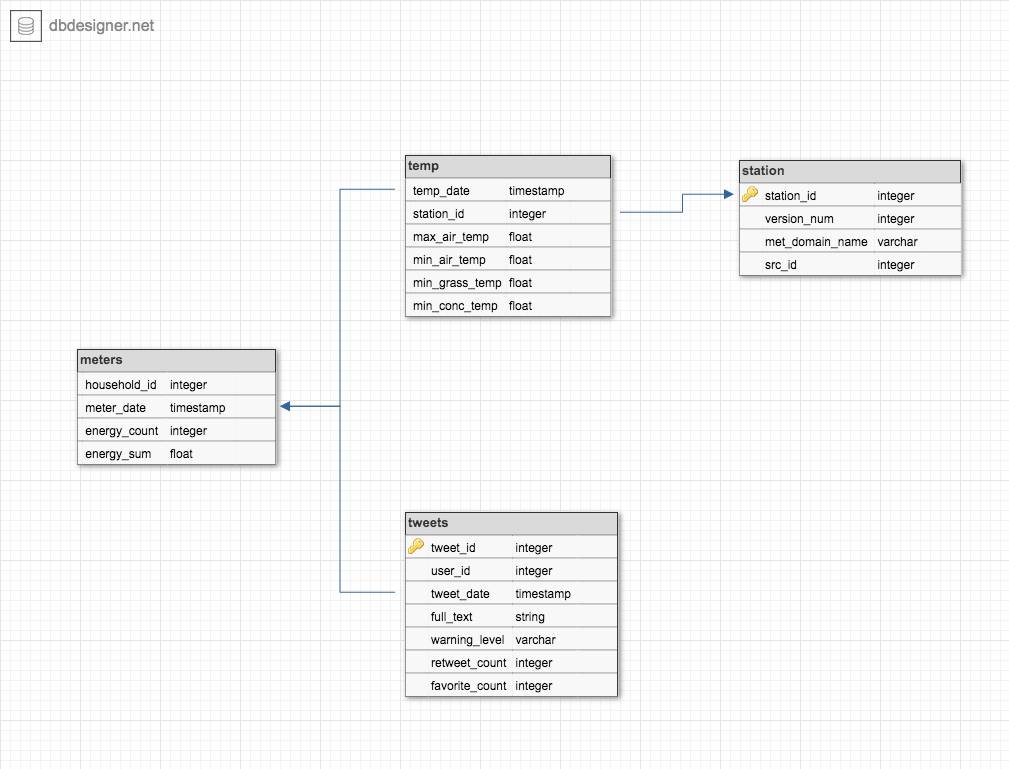

#### 3.2 Mapping Out Data Pipelines
To pipelines the data into the data model the following steps will be required.
1. Create a connection to AWS and launch a Redshift cluster. We will then perform the necessary steps to load the data first to S3 and then to Redshift.
2. Restructure the tables as required by the data model.  This will involve renaming, reordering and dropping columns to conform with the data model above.
3. Stage the data in S3 as csvs.  This will involve first outputting the data to csv files and then loading these csv files into S3.
4. Copy data from S3 to Redshift.  This will involve creating table shells with columns, data types and constraints and then copying the data from S3 into Redshift.

## Step 4: Run Pipelines to Model the Data 
### 4.1 Create the data model

#### 1. Create a connection to AWS and launch a Redshift cluster

In [61]:
def aws_config():
    """
    Read in the config file dwh.cfg and then set global variables such that we can commence IaC
    """

    global config, KEY, SECRET, DWH_CLUSTER_TYPE, DWH_NUM_NODES, DWH_NODE_TYPE, DWH_CLUSTER_IDENTIFIER, DWH_DB, DWH_DB_USER, DWH_DB_PASSWORD, DWH_PORT, DWH_IAM_ROLE_NAME

    config = configparser.ConfigParser()
    config.read_file(open('dwh.cfg'))
    
    KEY                    = config.get('AWS','KEY')
    SECRET                 = config.get('AWS','SECRET')

    DWH_CLUSTER_TYPE       = config.get("DWH","DWH_CLUSTER_TYPE")
    DWH_NUM_NODES          = config.get("DWH","DWH_NUM_NODES")
    DWH_NODE_TYPE          = config.get("DWH","DWH_NODE_TYPE")

    DWH_CLUSTER_IDENTIFIER = config.get("DWH","DWH_CLUSTER_IDENTIFIER")
    DWH_DB                 = config.get("DWH","DWH_DB")
    DWH_DB_USER            = config.get("DWH","DWH_DB_USER")
    DWH_DB_PASSWORD        = config.get("DWH","DWH_DB_PASSWORD")
    DWH_PORT               = config.get("DWH","DWH_PORT")

    DWH_IAM_ROLE_NAME      = config.get("DWH", "DWH_IAM_ROLE_NAME")

In [62]:
# Uncomment the following lines to confirm details of parameters that we will use to establish connection to AWS
# (DWH_DB_USER, DWH_DB_PASSWORD, DWH_DB)

# pd.DataFrame({"Param":
#                   ["DWH_CLUSTER_TYPE", "DWH_NUM_NODES", "DWH_NODE_TYPE", "DWH_CLUSTER_IDENTIFIER", "DWH_DB", "DWH_DB_USER", "DWH_DB_PASSWORD", "DWH_PORT", "DWH_IAM_ROLE_NAME"],
#               "Value":
#                   [DWH_CLUSTER_TYPE, DWH_NUM_NODES, DWH_NODE_TYPE, DWH_CLUSTER_IDENTIFIER, DWH_DB, DWH_DB_USER, DWH_DB_PASSWORD, DWH_PORT, DWH_IAM_ROLE_NAME]
#              })

In [63]:
def aws_client_resource():
    """
    Create clients / resources for ec2, S3, IAM, and Redshift
    """

    global ec2, s3, iam, redshift
    
    ec2 = boto3.resource('ec2',
                           region_name="us-west-2",
                           aws_access_key_id=KEY,
                           aws_secret_access_key=SECRET
                        )

    s3 = boto3.resource('s3'
                      , region_name = "us-east-1"
                      , aws_access_key_id = KEY
                      , aws_secret_access_key = SECRET)

    iam = boto3.client('iam'
                       , region_name = "us-east-1"
                       , aws_access_key_id = KEY
                       , aws_secret_access_key = SECRET)

    redshift = boto3.client('redshift'
                        , region_name = "us-east-1"
                        , aws_access_key_id = KEY
                        , aws_secret_access_key = SECRET)

In [64]:
def launch_aws():
    """
    Launch AWS using infrastructure as code:
    1. Create an IAM role
    2. Attach policy to the IAM role created
    3. Get the IAM role ARN
    4. Create Redshift Cluster
    """        
    # Create an IAM role
    try:
        print('1. Creating a new IAM Role')

        dwhRole = iam.create_role(
            Path = '/',
            RoleName = DWH_IAM_ROLE_NAME,
            Description = "Allows Redshift clusters to call AWS services on your behalf",
            AssumeRolePolicyDocument = json.dumps(
            {'Statement':[{'Action':'sts:AssumeRole',
                           'Effect':'Allow',
                           'Principal':{'Service':'redshift.amazonaws.com'}}],
            'Version':'2012-10-17'})
        )

    except Exception as e:
        print(e)

    # Attach Policy
    try:
        print('2. Attaching Policy')

        iam.attach_role_policy(RoleName = DWH_IAM_ROLE_NAME,
                              PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
                              )['ResponseMetadata']['HTTPStatusCode']

    except Exception as e:
        print(e)

    # Get and print the IAM role ARN
    print('3. Get the IAM role ARN')
    global roleArn
    roleArn = iam.get_role(RoleName=DWH_IAM_ROLE_NAME)['Role']['Arn']

    # Create a RedShift Cluster
    try:
        print('4. Create Redshift Cluster')
        response = redshift.create_cluster(        
            # Add parameters for hardware
            ClusterType=DWH_CLUSTER_TYPE
            , NodeType=DWH_NODE_TYPE
            , NumberOfNodes = int(DWH_NUM_NODES),

            # Add parameters for identifiers & credentials
            DBName = DWH_DB
            , ClusterIdentifier = DWH_CLUSTER_IDENTIFIER
            , MasterUsername = DWH_DB_USER
            , MasterUserPassword = DWH_DB_PASSWORD

            # Add parameter for role (to allow s3 access)
            , IamRoles = [roleArn]
        )

    except Exception as e:
        print(e)

In [100]:
# Describe the cluster
def prettyRedshiftProps(props):
    """
    Function from which we can describe the cluster
    """           
    pd.set_option('display.max_colwidth', -1)
    keysToShow = ["ClusterIdentifier", "NodeType", "ClusterStatus", "MasterUsername", "DBName", "Endpoint", "NumberOfNodes", 'VpcId']
    x = [(k, v) for k,v in props.items() if k in keysToShow]
    return pd.DataFrame(data=x, columns=["Key", "Value"])
    
    global myClusterProps
    myClusterProps = redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]

In [102]:
# Run functions to establish connections to AWS
aws_config()
aws_client_resource()
launch_aws()

1. Creating a new IAM Role
An error occurred (EntityAlreadyExists) when calling the CreateRole operation: Role with name dwhRole already exists.
2. Attaching Policy
3. Get the IAM role ARN
4. Create Redshift Cluster
An error occurred (ClusterAlreadyExists) when calling the CreateCluster operation: Cluster already exists
5. Create function from which we can describe the cluster


In [104]:
# Uncomment out the following line to see the cluster status
# prettyRedshiftProps(myClusterProps)

###  RUN THE FOLLOWING CODE ONCE THE CLUSTER IS AVAILABLE

In [67]:
DWH_ENDPOINT = myClusterProps['Endpoint']['Address']
DWH_ROLE_ARN = myClusterProps['IamRoles'][0]['IamRoleArn']

In [68]:
# Uncomment out the following two lines to see the cluster end point (host) and role arn
# print("DWH_ENDPOINT :: ", DWH_ENDPOINT)
# print("DWH_ROLE_ARN :: ", DWH_ROLE_ARN)

### NOTE:  Using AWS interface now assign a security group that allows TCP connection to port 5439

#### 2. Restructure the tables as required by the data model

In [69]:
def restructure_tables(meters_input, tweets_input, temp_input, station_input):
    """
    Restructure tables such that the tables and columns fit the data model:
    1. For each table keep only columns that are needed and rename to naming conventions of the data model
    2. For the temp table, as there are two readings per day, we will manipulate the data such that we take the min and max from each day
    3. Return the cleaned data
    """
    
    # Keep only the columns that we need as per the data model   
    meters_output = meters_input[['household_id', 'day', 'energy_count', 'energy_sum']]
    # Rename columns as required by the data model
    meters_output = meters_output.rename(columns={'day': 'meter_date'})
    
    # Repeat for all tables
    tweets_output = tweets_input[['tweet_id', 'user_id', 'created_at', 'full_text', 'warning_level', 'retweet_count', 'favorite_count']]
    tweets_output = tweets_output.rename(columns={'created_at': 'tweet_date'})
    
    temp_output = temp_input[['ob_end_time', 'id', 'max_air_temp', 'min_air_temp', 'min_grss_temp', 'min_conc_temp']]
    temp_output = temp_output.rename(columns={'ob_end_time':'temp_date','id':'station_id'})
          
    station_output = station_input[['id', 'version_num', 'met_domain_name', 'src_id']]
    station_output = station_output.rename(columns={'id':'station_id'})

    # Additional transformation required to temp_clean_df to get to one record per day.  Each row contains min and max reading and so we will keep the min and max across the two rows with the same date
    temp_clean_df_max_air_temp = temp_output[['temp_date','station_id','max_air_temp']].groupby('temp_date').max('max_air_temp').sort_values('temp_date')
    temp_clean_df_min_air_temp = temp_output[['temp_date','min_air_temp']].groupby('temp_date').min('min_air_temp').sort_values('temp_date')
    temp_clean_df_min_grss_temp = temp_output[['temp_date','min_grss_temp']].groupby('temp_date').min('min_grss_temp').sort_values('temp_date')
    temp_clean_df_min_conc_temp = temp_output[['temp_date','min_conc_temp']].groupby('temp_date').min('min_conc_temp').sort_values('temp_date')
    temp_output = pd.concat([temp_clean_df_max_air_temp, temp_clean_df_min_air_temp, temp_clean_df_min_grss_temp, temp_clean_df_min_conc_temp], axis=1, join="inner")
    temp_output = temp_output.reset_index()
    
    return meters_output, tweets_output, temp_output, station_output

In [70]:
meters_clean_df, tweets_clean_df, temp_clean_df, station_clean_df = restructure_tables(meters_clean_df, tweets_clean_df, temp_clean_df, station_clean_df)

In [71]:
# Check to confirm that the correct columns have been retained
meters_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   household_id  object        
 1   meter_date    datetime64[ns]
 2   energy_count  int64         
 3   energy_sum    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 107.1+ MB


In [72]:
tweets_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1103 entries, 0 to 1150
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1103 non-null   int64              
 1   user_id         1103 non-null   object             
 2   tweet_date      1103 non-null   datetime64[ns, UTC]
 3   full_text       1103 non-null   object             
 4   warning_level   1051 non-null   category           
 5   retweet_count   1103 non-null   int64              
 6   favorite_count  1103 non-null   int64              
dtypes: category(1), datetime64[ns, UTC](1), int64(3), object(2)
memory usage: 61.5+ KB


In [73]:
temp_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   temp_date      4018 non-null   datetime64[ns]
 1   station_id     4018 non-null   int64         
 2   max_air_temp   4018 non-null   float64       
 3   min_air_temp   4018 non-null   float64       
 4   min_grss_temp  4001 non-null   float64       
 5   min_conc_temp  4006 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 188.5 KB


In [74]:
station_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 0 to 0
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   station_id       1 non-null      int64 
 1   version_num      1 non-null      int64 
 2   met_domain_name  1 non-null      object
 3   src_id           1 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 40.0+ bytes


#### 3. Stage the data in S3 as csvs

In [75]:
def stage_s3(table, csv, s3_bucket):
    """
    Function to stage data in S3:
    1. Create a 'csvs' folder if it does not exist
    2. Create a csv for eaceh of the four dataframes
    3. Load each csv to an S3 bucket
    """
    # Create a folder for the csvs to be stored if it does not already exist
    directory = 'csvs'
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Create csvs from each of our four dataframes
    table.to_csv('csvs/' + csv, index=False, header=False)
    
    # Load the csv files to S3
    s3.Object(s3_bucket, csv).put(Body=open('csvs/' + csv, 'rb'))

In [76]:
stage_s3(meters_clean_df,'meters_clean_df.csv', 'dc-data-lake')
stage_s3(tweets_clean_df,'tweets_clean_df.csv', 'dc-data-lake')
stage_s3(temp_clean_df,'temp_clean_df.csv', 'dc-data-lake')
stage_s3(station_clean_df,'station_clean_df.csv', 'dc-data-lake')

#### 4. Copy data from S3 to Redshift

In [77]:
def get_cursor():
    """
    Function to get a cursor such that we can run sql statements on our Redshift cluster.
    """
    # Connect to the Redshift cluster
    %load_ext sql
    global conn
    conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(DWH_ENDPOINT, DWH_DB, DWH_DB_USER, DWH_DB_PASSWORD, DWH_PORT))
    global cur
    cur = conn.cursor()

In [78]:
def redshift_create_tables():   
    """
    Function to create table shells in Redshift that fit the data model
    """
    # Create table shells in Redshift so that we can later insert into these
    cur.execute("""
        DROP TABLE IF EXISTS "meters";
        CREATE TABLE IF NOT EXISTS "meters" (
            household_id VARCHAR,
            meter_date TIMESTAMP NOT NULL DISTKEY SORTKEY,
            energy_count INTEGER,
            energy_sum DOUBLE PRECISION
        );

        DROP TABLE IF EXISTS "tweets";
        CREATE TABLE IF NOT EXISTS "tweets" (
            tweet_id BIGINT PRIMARY KEY,
            user_id VARCHAR,
            tweet_date TIMESTAMP NOT NULL DISTKEY SORTKEY,
            full_text VARCHAR(560),
            warning_level VARCHAR,
            retweet_count INTEGER,
            favorite_count INTEGER
        );

        DROP TABLE IF EXISTS "temp";
        CREATE TABLE IF NOT EXISTS "temp" (
            temp_date TIMESTAMP NOT NULL DISTKEY SORTKEY,
            station_id INTEGER,
            max_air_temp DOUBLE PRECISION,
            min_air_temp DOUBLE PRECISION,
            min_grss_temp DOUBLE PRECISION,
            min_conc_temp DOUBLE PRECISION
        );

        DROP TABLE IF EXISTS station;
        CREATE TABLE IF NOT EXISTS station (
            station_id INTEGER PRIMARY KEY,
            version_num INTEGER,
            met_domain_name VARCHAR,
            src_id INTEGER
        );
    """
    )

    conn.commit()

In [79]:
def copy_to_redshift(table,s3_bucket,csv):
    """
    Function to copy the data from S3 to Redshift
    """
        
    # Create code that we will then execute to copy our data from S3 into Redshift
    sql_code = ("""
    COPY {}
    FROM '{}{}'
    IAM_ROLE '{}'
    CSV
    REGION 'us-east-1'
    """).format(table,s3_bucket,csv,roleArn)
    
    # Execute copy codes to load the data to Redshift
    cur.execute(sql_code)

In [80]:
# Run functions to copy data across to Redshift
get_cursor()
redshift_create_tables()
copy_to_redshift('meters','s3://dc-data-lake/','meters_clean_df.csv')
copy_to_redshift('tweets','s3://dc-data-lake/','tweets_clean_df.csv')
copy_to_redshift('temp','s3://dc-data-lake/','temp_clean_df.csv')
copy_to_redshift('station','s3://dc-data-lake/','station_clean_df.csv')

### 4.2 Data Quality Checks

For each table in turn perform the following checks,
- Check that there are records populated in each table
- Check that columns which have primary key or non null constraints do not return null values
- All tables, columns and data types match the model
- Analytics query can be run across the model

Then finally run a script to check that the tables join together as intended.

In [81]:
def data_quality_check_records_populated(table):
    """
    Data quality check to ensure that records have been populated in the table
    """
    sql_code = ("""
    SELECT COUNT(*) FROM {}
    """).format(table)
    
    cur.execute(sql_code)
    
    no_records = cur.fetchall()[0][0]

    if no_records > 0:
        print("DQ PASS - " + str(no_records) + " records populated in " + table + " table.")
        
    elif no_records == 0:
        print("DQ FAIL - " + str(no_records) + " records populated in " + table + " table.")

    else:
        print("DQ ERROR - check on records populated not completed on " + table + " table.")


In [82]:
tables = ["meters","tweets","temp","station"]

In [83]:
for table in tables:
    data_quality_check_records_populated(table)

DQ PASS - 3510433 records populated in meters table.
DQ PASS - 1103 records populated in tweets table.
DQ PASS - 4018 records populated in temp table.
DQ PASS - 1 records populated in station table.


In [84]:
def data_quality_check_null_records_populated(table,columns):
    """
    Data quality check to ensure that there are no null records in primary keys or non null keys as per data model constraints
    """    
    sql_code = ("""
    SELECT COUNT(*) FROM {} WHERE {} IS NULL
    """).format(table,column)
    
    cur.execute(sql_code)
    
    no_records = cur.fetchall()[0][0]

    if no_records == 0:
        print("DQ PASS - " + str(no_records) + " null records populated in column " + column + " from " + table + " table.")
        
    elif no_records > 0:
        print("DQ FAIL - " + str(no_records) + " null records populated in column " + column + " from " + table + " table.")

    else:
        print("DQ ERROR - check on null records populated not completed on column " + column + " from " + table + " table.")


In [85]:
tables_columns = [("meters","meter_date"),("tweets","tweet_id"),("tweets","tweet_date"),("temp","temp_date")]

In [86]:
for table, column in tables_columns:
    data_quality_check_null_records_populated(table, column)

DQ PASS - 0 null records populated in column meter_date from meters table.
DQ PASS - 0 null records populated in column tweet_id from tweets table.
DQ PASS - 0 null records populated in column tweet_date from tweets table.
DQ PASS - 0 null records populated in column temp_date from temp table.


In [87]:
def data_quality_check_data_model(table):
    """
    Output schema for each table to confirm that it matches the data model
    """    
    sql_code = ("""
    SELECT * FROM pg_table_def WHERE tablename = '{}'
    """).format(table)

# PASS - data types as expected
    cur.execute(sql_code)
    
    output = pd.DataFrame(cur.fetchall())
    
    return print(output)

In [88]:
for table in tables:
    data_quality_check_data_model(table)
# Demonstrates that all tables and columns as per the data model are present

        0       1             2                            3     4      5  6  \
0  public  meters  household_id       character varying(256)   lzo  False  0   
1  public  meters    meter_date  timestamp without time zone  none   True  1   
2  public  meters  energy_count                      integer  az64  False  0   
3  public  meters    energy_sum             double precision  none  False  0   

       7  
0  False  
1   True  
2  False  
3  False  
        0       1               2                            3     4      5  \
0  public  tweets        tweet_id                       bigint  az64  False   
1  public  tweets         user_id       character varying(256)   lzo  False   
2  public  tweets      tweet_date  timestamp without time zone  none   True   
3  public  tweets       full_text       character varying(560)   lzo  False   
4  public  tweets   warning_level       character varying(256)   lzo  False   
5  public  tweets   retweet_count                      integer  az64  

In [89]:
def data_quality_check_joins():
    """
    Data quality check to ensure that joins across entire data model result in output.
    Inner join would result in 0 records if one join fails.
    """    
    # Check that the joins work and that data can be joined together as intended
    sql_code = ("""
    SELECT COUNT(*)
    FROM meters AS a
    INNER JOIN tweets AS b
         ON meter_date = tweet_date
    INNER JOIN temp AS c
         ON meter_date = temp_date
    INNER JOIN station AS d
         ON c.station_id = d.station_id
    """)
    
    cur.execute(sql_code)
    
    no_records = cur.fetchall()[0][0]

    if no_records > 0:
        print("DQ PASS - join successful.")
        
    elif no_records == 0:
        print("DQ FAIL - join unsuccessful.")

    else:
        print("DQ ERROR - check on joins not completed.")


In [90]:
data_quality_check_joins()
# Demonstrates that all joins as per the data model can be made

DQ PASS - join successful.


In [91]:
def analysis_query():
    """
    Run an analysis query to ensure that the model can be used to pull data from across all tables.
    """    
    # Check that the joins work and that data can be joined together as intended
    sql_code = ("""
    SELECT DISTINCT src_id, warning_level, AVG(energy_sum)
    FROM meters AS a
    INNER JOIN tweets AS b
         ON meter_date = tweet_date
    INNER JOIN temp AS c
         ON meter_date = temp_date
    INNER JOIN station AS d
         ON c.station_id = d.station_id
    GROUP BY src_id, warning_level
    """)
    
    cur.execute(sql_code)
    
    return print(cur.fetchall())

In [92]:
analysis_query()
# Demonstrates that during Amber weather warning energy consumption on average is higher.

[(708, 'Yellow', 10.9086492113), (708, '', 11.0147053721469), (708, 'Amber', 11.457690435183)]


### Uncomment out the following two cells once data load is complete shut down the Redshift Cluster
- Note:  in a production environment this would not be run

In [113]:
# Delete the cluster
# redshift.delete_cluster( ClusterIdentifier=DWH_CLUSTER_IDENTIFIER,  SkipFinalClusterSnapshot=True)

In [1]:
# Check that the cluster has been succesfully deleted
# myClusterProps = redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]
# prettyRedshiftProps(myClusterProps)

### 4.3 Data dictionary 


**meters table (fact)**
- household_id (bigint, composite key) - a unique identifier at household level
- meter_date (timestamp, foreign key, composite key, distkey, sortkey) - date stamp
- energy_count (integer) - number of energy readings taken by the smart meter in the given day
- energy_sum (float) - sum of energy usage on given day

The meters table data is taken from a large dataset containing readings from smart meters in London (sourced from Kaggle) - https://www.kaggle.com/jeanmidev/smart-meters-

**tweets table (dimension)**
- tweet_id (integer, primary key) - unique identifier for the tweet
- user_id - twitter handle for the account that created the tweet
- tweet_date (timestamp, foreign key, distkey, sortkey) - timestamp for the tweet
- full_text (varchar) - full text from the tweet
- warning_level (varchar) - derived field containing the warning level associated with the tweet
- retweet_count (integer) - count of number of times the tweet has been retweeted
- favorite_count (integer) - count of number of times the tweet has been favourited

The tweets table data is sourced using the Tweepy API from the twitter page Met Office weather warnings for South East England (sourced from Twitter via API) - https://twitter.com/metofficeSEEng

**temp table (dimension)**
- temp_date (timestamp, foreign key, composite key) - date and time at end of observation
- station_id (integer, foreign key, composite key) - station identifier
- max_air_temp (float) - maximum air temperature recorded during the observation period
- min_air_temp (float) - minimum air temperature recorded during the observation period
- min_grss_temp (float) - minimum grass temperature recorded during the observation period
- min_conc_temp (float) - minimum concrete temperature recorded during the observation period

The temp table data is taken from CEDA dataset of temperature data by day for Heathrow (London) (sourced from CEDA) - https://data.ceda.ac.uk/badc/ukmo-midas-open/data/uk-daily-temperature-obs/dataset-version-202107/greater-london/00708_heathrow/qc-version-1

**station table (dimension)**
- station_id (integer, foreign key, primary key) - station identifier
- version_num - the midas_qc_version_number indicates if the data are original received message (0) or current best version (1)
- met_domain_name - message type
- src_id - unique MIDAS source identifier

The station table data is also taken from the CEDA datset of temperature data.  The station table has been derived from the temp table and acts as a lookup table.

## Step 5: Complete Project Write Up

##### Rational for the choice of tools and technologies

The initial steps of this project have been completed on a local instance of Python.  The data is small enough that this allows for gathering, assessing and cleaning of the data.

Once the data has been cleaned it is then written to csv files which are loaded to an S3 data lake.  This wil allow access to the data by a wider range of users.

A Redshift Cluster is then launched using an infrastructure as code appoach.  This ensures that the Cluster can easily be replicated and governed.

From S3 the data is copied to Redshift as a data warehouse where it can then be accessed by the Analytics team to perform their analysis.

##### Update frequency
The smart meters data is a static database which is cut at 2019.  However it is proposed that the data should be updated on a daily basis once this is reinstated to allow daily readings to be loaded into the Analytics database such that the team can access the latest data.  This will also allow early detection and analysis of spikes or dips in energy usage and allow quick investigation of the drivers.

##### Alternative scenarios

The problem would require a change in approach under the following scenarios::
- The data was increased by 100x.
Under this scenario I would process user Spark process the data given that it is designed to handle Big Data.  The distributed system under Spark would support this whereas the current process could not.

- The data populates a dashboard that must be updated on a daily basis by 7am every day.
Under this scenario I would build a DAG using Apache Airflow and set this to a daily schedule to run each day at 7am.

- The database needed to be accessed by 100+ people.
The Redshift Cluster is capable of handling such a population of users accessing the database and therefore it can continue to reside in Redshift under this scenario.